In [2]:
1+2+3

6

# FOLD

In [2]:
import tensorflow as tf
from sklearn.model_selection import KFold
from sklearn.metrics import confusion_matrix
from tensorflow.keras import datasets, layers, models
import numpy as np
import matplotlib.pyplot as plt

import h5py
import numpy as np

import pickle
import tensorflow as tf

def save_history(history, filename):
    with open(filename, 'wb') as f:
        pickle.dump(history.history, f)

def load_history(filename):
    with open(filename, 'rb') as f:
        history = tf.keras.callbacks.History()
        history.history = pickle.load(f)
    return history

from matplotlib import pyplot as plt

def plot_history(hist):
    plt.plot([acc * 100 for acc in hist['accuracy']])
    plt.plot([acc * 100 for acc in hist['val_accuracy']])

    plt.ylabel('Accuracy (%)')

    plt.title('Résultat d\'entraînement et de validation')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'val'], loc='upper left')

    # hide bordure
    plt.gca().spines['top'].set_visible(False)
    plt.gca().spines['right'].set_visible(False)
    plt.gca().spines['bottom'].set_visible(False)
    plt.gca().spines['left'].set_visible(False)

    plt.grid(axis='y')

    #plt.savefig("/kaggle/working/class2.svg")

    print("Done")
    plt.show()


def concatenate_histories(*histories):
    hist = {}
    hist['loss'] = []
    hist['val_loss'] = []
    hist['accuracy'] = []
    hist['val_accuracy'] = []

    for history in histories:
        hist['loss'] += history.history['loss']
        hist['val_loss'] += history.history['val_loss']
        if 'accuracy' in history.history:
            hist['accuracy'] += history.history['accuracy']
            hist['val_accuracy'] += history.history['val_accuracy']

    return hist

f = h5py.File('../input/lungnodemalignancy/all_patches.hdf5','r')

ct_slices = f['ct_slices']
slice_class = f['slice_class']

ct_slices = np.array(ct_slices)
slice_class = np.array(slice_class)

print(ct_slices.shape)
print(slice_class.shape)
print(ct_slices[1].min())

from sklearn.model_selection import train_test_split
from tensorflow import keras
ct_slices = ct_slices.reshape(6691,64,64,1)

X_train, X_test, y_train, y_test = train_test_split(ct_slices, slice_class, test_size=0.20, random_state=42)

y_train = keras.utils.to_categorical(y_train, num_classes=2)
y_test = keras.utils.to_categorical(y_test, num_classes=2)


print(X_train.shape)
print(y_train.shape)

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:98: UserWarning: unable to load libtensorflow_io_plugins.so: unable to open file: libtensorflow_io_plugins.so, from paths: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so']
caused by: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so: undefined symbol: _ZN3tsl6StatusC1EN10tensorflow5error4CodeESt17basic_string_viewIcSt11char_traitsIcEENS_14SourceLocationE']
  warnings.warn(f"unable to load libtensorflow_io_plugins.so: {e}")
/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:104: UserWarning: file system plugins are not loaded: unable to open file: l

(6691, 64, 64)
(6691, 1)
-1024.0
(5352, 64, 64, 1)
(5352, 2)


In [78]:
from keras.models import Sequential

from keras.layers import Conv2D, MaxPooling2D, GlobalAveragePooling2D, Flatten, Dense, RandomFlip, RandomRotation

def create_model():
    print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

    # Create a MirroredStrategy for two T4 GPUs
    strategy = tf.distribute.MirroredStrategy(["GPU:0", "GPU:1"])
    print('Number of devices: {}'.format(strategy.num_replicas_in_sync))

    # Open a strategy scope and create the model
    with strategy.scope():
        model = Sequential()
        model.add(RandomFlip("horizontal_and_vertical"))
        model.add(RandomRotation(1.0))

        model.add(Conv2D(64, kernel_size=(8, 8), activation='relu', padding='same',input_shape=(64,64,1)))
        model.add(Conv2D(64, kernel_size=(2, 2), activation='relu', padding='same'))

        model.add(MaxPooling2D(pool_size=(8, 8), name="max_pooling2d_1"))

        model.add(Conv2D(64, kernel_size=(2, 2), activation='softmax', padding='same'))
        model.add(Conv2D(64, kernel_size=(2, 2), activation='relu', padding='same'))

        model.add(MaxPooling2D(pool_size=(2, 2), name="max_pooling2d_2"))

        model.add(Conv2D(64, kernel_size=(2, 2), activation='relu', padding='same'))
        model.add(Conv2D(64, kernel_size=(2, 2), activation='relu', padding='same'))
        model.add(Conv2D(64, kernel_size=(8, 8), activation='relu', padding='same')) #add this
        model.add(MaxPooling2D(pool_size=(2, 2), name="max_pooling2d_3"))

        model.add(GlobalAveragePooling2D())
        model.add(Flatten())

        model.add(Dense(2, activation='softmax'))

        model.compile(loss=keras.losses.categorical_crossentropy,
                      #optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
                      optimizer=tf.keras.optimizers.Adam(),
                      metrics=['accuracy'])

    return model

In [24]:
model_3=create_model()

Num GPUs Available:  0
Number of devices: 2


In [100]:
#model_2.compile(loss=keras.losses.categorical_crossentropy, optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), metrics=['accuracy'])

In [65]:
%%time
#history_1 = model_3.fit( X_train,y_train, batch_size=640, epochs=6, validation_data=(X_test, y_test))
#model_3.save('/kaggle/working/save3/model3_4.h5')
#save_history(history_1, '/kaggle/working/save3/history_4.h5')

CPU times: user 4 µs, sys: 0 ns, total: 4 µs
Wall time: 9.78 µs


In [56]:
from keras.models import load_model

#model_4   = load_model('/kaggle/working/save3/model3_4.h5')
#history_2 = load_history('/kaggle/working/save3/history_2.h5')

In [ ]:
%%time
## shange modeil hyperParam
#model_3.compile(loss=keras.losses.categorical_crossentropy,optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),metrics=['accuracy'])
#history_2 = model_3.fit( X_train,y_train, batch_size=32, epochs=10, validation_data=(X_test, y_test))


In [80]:
%%time
tensorboard_callback = tf.keras.callbacks.TensorBoard("logs")

#history_5 = model_5.fit( X_train,y_train, batch_size=640, epochs=1000, validation_data=(X_test, y_test),callbacks=[tensorboard_callback],)
model_5.save('/kaggle/working/save3/model3_5.h5')
save_history(history_5, '/kaggle/working/save3/history_5.h5')

CPU times: user 66 ms, sys: 6.2 ms, total: 72.2 ms
Wall time: 70.4 ms


In [59]:
model_4.summary()

Model: "sequential_18"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 random_flip_18 (RandomFlip)  (None, 64, 64, 1)        0         
                                                                 
 random_rotation_18 (RandomR  (None, 64, 64, 1)        0         
 otation)                                                        
                                                                 
 conv2d_51 (Conv2D)          (None, 64, 64, 64)        4160      
                                                                 
 conv2d_52 (Conv2D)          (None, 64, 64, 64)        16448     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 8, 8, 64)         0         
 2D)                                                             
                                                                 
 conv2d_53 (Conv2D)          (None, 8, 8, 64)        

In [75]:
!mkdir -p /kaggle/working/save5/
model_5.save_weights('/kaggle/working/save5/model5_weights.h5')
model_6=create_model()
history_6 = model_6.fit( X_train,y_train, batch_size=640, epochs=1, validation_data=(X_test, y_test))
model_6.load_weights('/kaggle/working/save5/model5_weights.h5', by_name=True)
model_6.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 random_flip_2 (RandomFlip)  (None, 64, 64, 1)         0         
                                                                 
 random_rotation_2 (RandomRo  (None, 64, 64, 1)        0         
 tation)                                                         
                                                                 
 conv2d_27 (Conv2D)          (None, 64, 64, 64)        4160      
                                                                 
 conv2d_28 (Conv2D)          (None, 64, 64, 64)        16448     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 8, 8, 64)         0         
 2D)                                                             
                                                                 
 conv2d_29 (Conv2D)          (None, 8, 8, 64)         

In [30]:
combined_history = concatenate_histories(
     history_1,
     history_2,
     history_3,
     history_4,
#      history_5,
#      history_6,
#      history_7,
#      history_8,
#      history_9,
)

Done


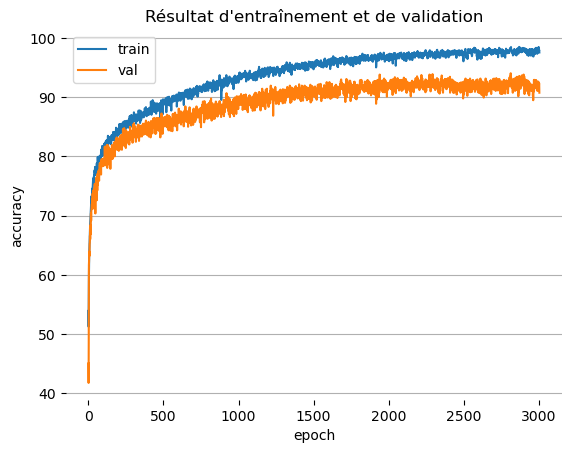

In [31]:
plot_history(combined_history)

Done


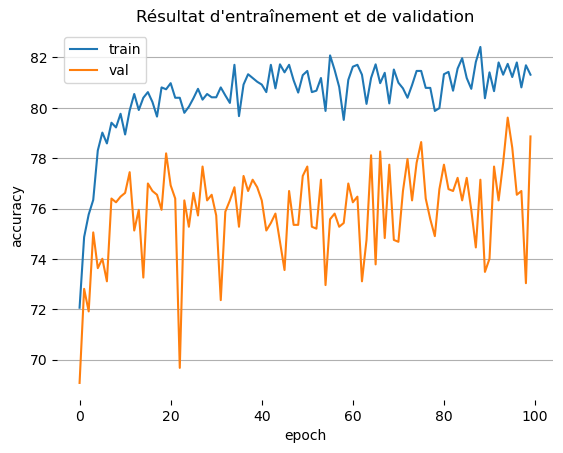

In [214]:
plot_history(history_11.history)

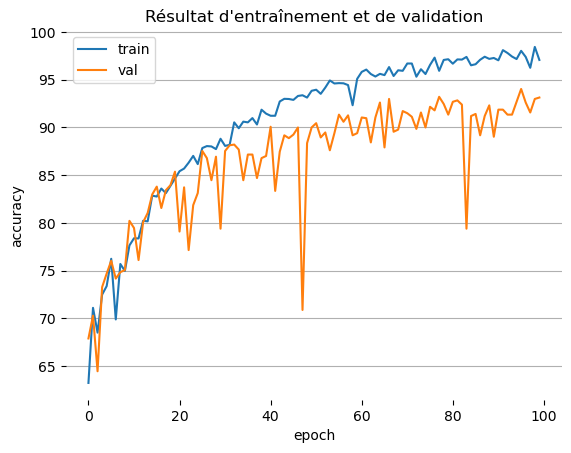

V4 batch_size=32, epochs=100, conv=128m rate=0.001, => loss=[1,4] kernel=[8.8]

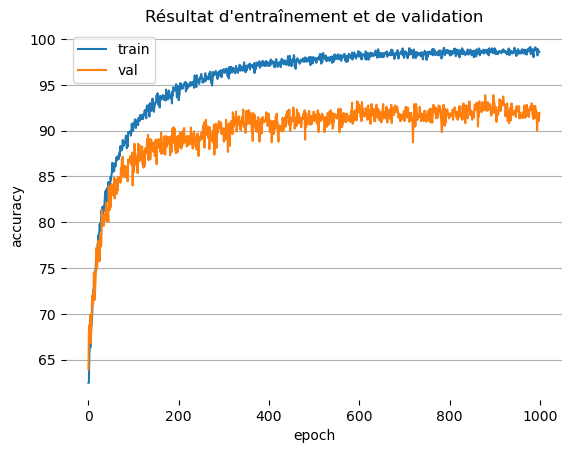

V4 batch_size=32, epochs=100, conv=2x256+128x3 rate=0.001, => loss=[1,4] kernel=[16.16] +[4,4]

In [58]:
# Clear any logs from previous runs
!rm -rf ./logs/ 
!mkdir ./logs/
!rm -rf ngrok*

!wget https://bin.equinox.io/c/bNyj1mQVY4c/ngrok-v3-stable-linux-amd64.tgz
!tar xvzf ngrok-v3-stable-linux-amd64.tgz
#!wget https://bin.equinox.io/c/4VmDzA7iaHb/ngrok-stable-linux-amd64.zip
#!unzip ngrok-stable-linux-amd64.zip
!ls
!chmod +x ngrok

--2023-07-11 22:32:27--  https://bin.equinox.io/c/bNyj1mQVY4c/ngrok-v3-stable-linux-amd64.tgz
Resolving bin.equinox.io (bin.equinox.io)... 52.202.168.65, 54.237.133.81, 18.205.222.128, ...
Connecting to bin.equinox.io (bin.equinox.io)|52.202.168.65|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 8850130 (8.4M) [application/octet-stream]
Saving to: ‘ngrok-v3-stable-linux-amd64.tgz’

ngrok-v3-stable-lin 100%[===================>]   8.44M  13.3MB/s    in 0.6s    

2023-07-11 22:32:28 (13.3 MB/s) - ‘ngrok-v3-stable-linux-amd64.tgz’ saved [8850130/8850130]

ngrok
 __notebook_source__.ipynb   history_v3.h5    ngrok
 class1.svg		     logs	      ngrok-v3-stable-linux-amd64.tgz
 class2.svg		    'model.pkl '      save
 history.h5		     model_luna1.h5   save2
'history.pkl '		     model_luna3.h5   save3
 history_luna1.h5	     model_v3.h5      state.db
 history_luna3.h5	     my_model.h5


In [12]:
# Run tensorboard as well as Ngrox (for tunneling as non-blocking processes)
import os
import multiprocessing

!chmod +x ./ngrok
!pkill ngrok
!./ngrok authtoken '1oVXOlOBg8Zf5vO2XoSgHzpf6E6_6jrnh4yJzYm2RTYzApjV5'
!pkill tensorbroad
!apt install lsof -y 1>/dev/null
!kill $(lsof -t -i:6006) 2>/dev/null

                            
pool = multiprocessing.Pool(processes = 10)
results_of_processes = [pool.apply_async(os.system, args=(cmd, ), callback = None )
                        for cmd in [
                            "tensorboard --logdir /kaggle/working/logs --host 0.0.0.0 --port 6006 &",
                            "./ngrok http 6006 &"
                        ]]


Authtoken saved to configuration file: /root/.config/ngrok/ngrok.yml




TensorBoard caught SIGTERM; exiting...


curl: /opt/conda/lib/libcurl.so.4: no version information available (required by curl)
https://d897-34-91-185-247.ngrok-free.app


/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:98: UserWarning: unable to load libtensorflow_io_plugins.so: unable to open file: libtensorflow_io_plugins.so, from paths: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so']
caused by: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so: undefined symbol: _ZN3tsl6StatusC1EN10tensorflow5error4CodeESt17basic_string_viewIcSt11char_traitsIcEENS_14SourceLocationE']
  warnings.warn(f"unable to load libtensorflow_io_plugins.so: {e}")
/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:104: UserWarning: file system plugins are not loaded: unable to open file: l

In [14]:
!curl -s http://localhost:4040/api/tunnels | python3 -c \
    "import sys, json; print(json.load(sys.stdin)['tunnels'][0]['public_url'])"

curl: /opt/conda/lib/libcurl.so.4: no version information available (required by curl)
https://d897-34-91-185-247.ngrok-free.app


Reading package lists... Done
Building dependency tree       
Reading state information... Done
The following NEW packages will be installed:
  lsof
0 upgraded, 1 newly installed, 0 to remove and 6 not upgraded.
Need to get 252 kB of archives.
After this operation, 466 kB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu focal-updates/main amd64 lsof amd64 4.93.2+dfsg-1ubuntu0.20.04.1 [252 kB]
Fetched 252 kB in 0s (540 kB/s)0m

78Selecting previously unselected package lsof.
(Reading database ... 107656 files and directories currently installed.)
Preparing to unpack .../lsof_4.93.2+dfsg-1ubuntu0.20.04.1_amd64.deb ...
7Progress: [  0%] [..........................................................] 87Progress: [ 20%] [###########...............................................] 8Unpacking lsof (4.93.2+dfsg-1ubuntu0.20.04.1) ...
7Progress: [ 40%] [#######################...................................] 8Setting up lsof (4.93.2+dfsg-1ubuntu0.20.04.1) ..